In [1]:
"""
Deutsch-Jozsa Benchmark Program - Qiskit
"""

import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = [ "_common", "_common/qiskit" ]
sys.path[1:1] = [ "../../_common", "../../_common/qiskit" ]
import execute as ex
import metrics as metrics

In [2]:
# Benchmark Name
benchmark_name = "Deutsch-Jozsa"

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
C_ORACLE_ = None
B_ORACLE_ = None 

In [3]:
############### Circuit Definition

# Create a constant oracle, appending gates to given circuit
def constant_oracle (input_size, num_qubits):
    #Initialize first n qubits and single ancilla qubit
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    output = np.random.randint(2)
    if output == 1:
        qc.x(input_size)

    global C_ORACLE_
    if C_ORACLE_ == None or num_qubits <= 6:
        if num_qubits < 9: C_ORACLE_ = qc

    return qc

In [4]:
# Create a balanced oracle.
# Perform CNOTs with each input qubit as a control and the output bit as the target.
# Vary the input states that give 0 or 1 by wrapping some of the controls in X-gates.
def balanced_oracle (input_size, num_qubits):
    #Initialize first n qubits and single ancilla qubit
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    # permit input_string up to num_qubits chars
    # e.g. b_str = "10101010101010101010"
    b_str = ""
    for i in range(input_size): b_str += '1' if i % 2 == 0 else '0'

    # map 1's to X gates
    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    qc.barrier()

    for qubit in range(input_size):
        qc.cx(qubit, input_size)

    qc.barrier()

    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    global B_ORACLE_
    if B_ORACLE_ == None or num_qubits <= 6:
        if num_qubits < 9: B_ORACLE_ = qc

    return qc

In [5]:
# Create benchmark circuit
def DeutschJozsa (num_qubits, type):
    
    # Size of input is one less than available qubits
    input_size = num_qubits - 1

    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(input_size);
    qc = QuantumCircuit(qr, cr, name=f"dj-{num_qubits}-{type}")

    for qubit in range(input_size):
        qc.h(qubit)
    qc.x(input_size)
    qc.h(input_size)
    
    qc.barrier()
    
    # Add a constant or balanced oracle function
    if type == 0: Uf = constant_oracle(input_size, num_qubits)
    else: Uf = balanced_oracle(input_size, num_qubits)
    qc.append(Uf, qr)

    qc.barrier()
    
    for qubit in range(num_qubits):
        qc.h(qubit)
    
    # uncompute ancilla qubit, not necessary for algorithm
    qc.x(input_size)
    
    qc.barrier()
    
    for i in range(input_size):
        qc.measure(i, i)
    
    # save smaller circuit and oracle subcircuit example for display
    global QC_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc

    # return a handle to the circuit
    return qc

In [6]:
############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the type, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, type, num_shots):
    
    # Size of input is one less than available qubits
    input_size = num_qubits - 1

    # obtain counts from the result object
    counts = result.get_counts(qc)
    if verbose: print(f"For type {type} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    if type == 0: key = '0'*input_size
    else: key = '1'*input_size
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

In [7]:
################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits=2, max_qubits=31, skip_qubits=1, max_circuits=3, num_shots=1000,
        backend_id='qasm_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, type, num_shots):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(type), num_shots)
        metrics.store_metric(num_qubits, type, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)       
    
    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2, max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over only 2 circuits
        for type in range( num_circuits ):
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = DeutschJozsa(num_qubits, type)
            metrics.store_metric(num_qubits, type, 'create_time', time.time()-ts)

            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, type, num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
    
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # # print a sample circuit
    # print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    # print("\nConstant Oracle 'Uf' ="); print(C_ORACLE_ if C_ORACLE_ != None else " ... too large or not used!")
    # print("\nBalanced Oracle 'Uf' ="); print(B_ORACLE_ if B_ORACLE_ != None else " ... too large or not used!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")

Deutsch-Jozsa Benchmark Program - Qiskit
... execution starting at Jun 04, 2024 11:20:20 UTC
************
Executing [2] circuits with num_qubits = 2
************
Executing [2] circuits with num_qubits = 3
************
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 6, 0.056
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 6, 0.056, 0.5
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.001, 0.046, 0.002 secs
Average Transpiling, Validating, Running Times for group 2 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 0.998, 0.996

************
Executing [2] circuits with num_qubits = 4
************
Executing [2] circuits with num_qubits = 5
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 8, 0.083
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 8, 0.071, 1.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.0

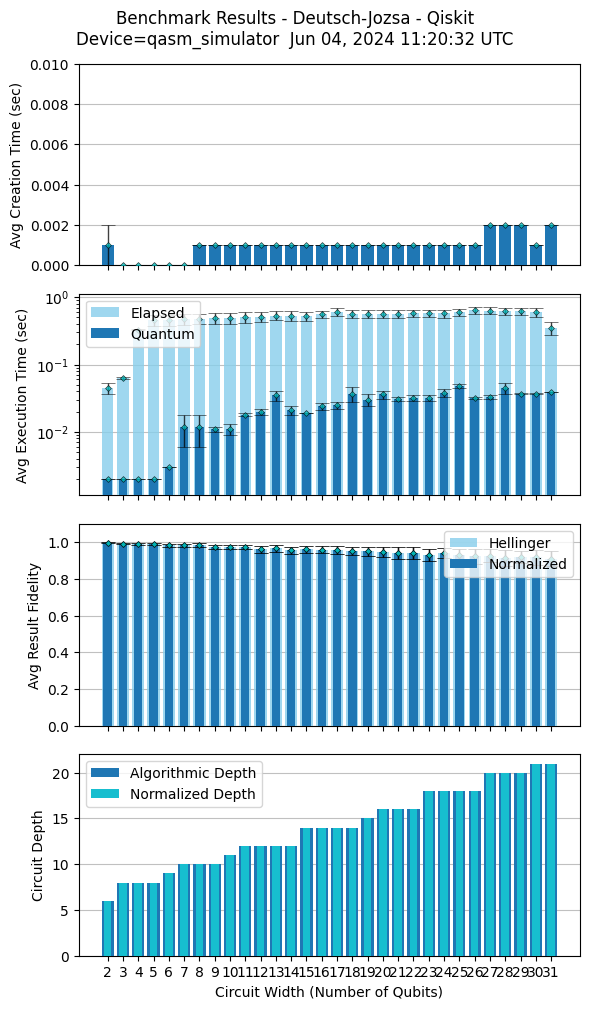

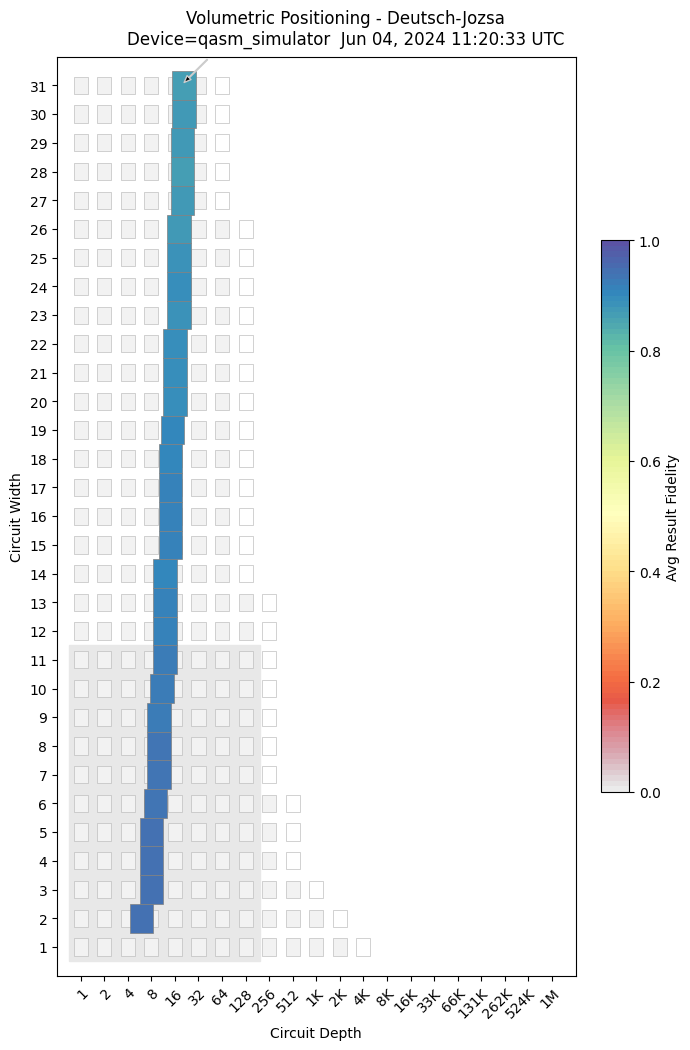

In [8]:
# if main, execute method
if __name__ == '__main__': run()